# Open-source LLM's as Agents with `ChatHuggingFace`


Open source LLMs are becoming viable general purpose agents. The goal of this notebook is to demonstrate how to make use of open-source LLMs as chat models using [Hugging Face Inference Endpoints](https://huggingface.co/docs/inference-endpoints/index) with [LangChain's `ChatHuggingFace`]() to enable their usage and experimentation with agent-based workflows.

In particular, we will:
1. Utilize the [HuggingFaceEndpoint](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/llms/huggingface_endpoint.py) (or [HuggingFaceTextGenInference](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/llms/huggingface_text_gen_inference.py) or [HuggingFaceHub](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/llms/huggingface_hub.py)) integration to call a [HF Inference Endpoint](https://huggingface.co/inference-endpoints) that's serving an LLM via [Text Generation Inference (TGI)](https://huggingface.co/docs/text-generation-inference/index)
2. Utilize the `ChatHuggingFace` class that interfaces between LangChain's [Chat Messages](https://python.langchain.com/docs/modules/model_io/chat/#messages) and the hosted LLM by leveraging [Hugging Face's Chat Templates](https://huggingface.co/docs/transformers/chat_templating) to power a `ChatAgent` pipeline.
4. Demonstrate how to use an open-source LLM in a zero-shot ReAct Agent workflow, along with an open-source [Prometheus](https://huggingface.co/papers/2310.08491) model to perform "LLM as a Judge"-style evaluations on that Agent's ouputs.
5. Understand how several different open-source LLM's perform as general purpose agents by running an asynchronous evaluation pipeline using Prometheus as the judge. 



> Note: To run this notebook, you'll need to have:
> - an LLM deployed via a Hugging Face Inference Endpoint (the LLM must have a `chat_template` defined in its `tokenizer_config.json`)
> - A Hugging Face Token with access to the deployed endpoint saved as an environment variable: `HUGGINGFACEHUB_API_TOKEN`
> - A SerpAPI key saved as an environment variable: `SERPAPI_API_KEY`


## Setup

In [31]:
!pip install -q transformers langchain text-generation python-dotenv jinja2 langchainhub numexpr datasets tqdm openai sentencepiece protobuf matplotlib wikipedia google-search-results


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# ruff: noqa: E402

from dotenv import load_dotenv
import numpy as np
import pandas as pd
import glob
from tqdm.notebook import tqdm


from langchain.agents.format_scratchpad import format_log_to_str
from langchain.agents import AgentExecutor
from langchain.agents.output_parsers import (
    ReActJsonSingleInputOutputParser,
)
from prompts import SYSTEM_PROMPT, HUMAN_PROMPT
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.tools import WikipediaQueryRun, tool
from langchain.utilities import WikipediaAPIWrapper
from langchain.agents import load_tools
from langchain.tools.render import render_text_description_and_args

load_dotenv(override=True)

True

## 1. Instantiate an LLM

You'll need to have a running Inference Endpoint available.

#### `HuggingFaceHub`

In [ ]:
from langchain.llms.huggingface_hub import HuggingFaceHub

llm = HuggingFaceHub(
    repo_id='HuggingFaceH4/zephyr-7b-beta',
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 50,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

#### `HuggingFaceEndpoint`

In [ ]:
from langchain.llms import HuggingFaceEndpoint

endpoint_url = "https://j02macig8fbovqhr.us-east-1.aws.endpoints.huggingface.cloud"  # zephyr
# endpoint_url = 'https://jetux1zl70hht8g2.us-east-1.aws.endpoints.huggingface.cloud'  # mixtral
llm = HuggingFaceEndpoint(
    endpoint_url=endpoint_url,
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 488,
        "top_k": 50,
        "repetition_penalty": 1.03,
    },
)

## 2. Create a wrapper for `BaseChatModel` to apply chat templates

In [ ]:
from langchain.schema import HumanMessage
from chat_wrapper import HuggingFaceChatWrapper

Instantiate the model and some messages to pass.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
messages = [
    HumanMessage(content="You're a helpful assistant. What happens when an unstoppable force meets an immovable object?"),
]

chat_model = HuggingFaceChatWrapper(llm=llm)
chat_model.model_id

Call the model.

In [ ]:
res = chat_model.invoke(messages)
print(res.content)

## Tests

Here we'll test out our model as a zero-shot ReAct Agent. The example below is taken from [here](https://python.langchain.com/docs/modules/agents/agent_types/react#using-chat-models).

Configure the agent with a `react-json` style prompt and access to a search engine and calculator.

### Define tools

In [ ]:
tools = load_tools(["serpapi", "llm-math"], llm=llm)
# Rename tools in the same format used by other tools
tools[0].name = "search"
tools[1].name = "calculator"

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

@tool
def search_wikipedia(query: str) -> str:
    """Searches Wikipedia for a query. This will not be relevant for the latest information, but it can be useful for historical knowledge."""
    return wikipedia.run(query)


TOOLS = tools + [search_wikipedia]

In [ ]:
prompt = ChatPromptTemplate.from_messages(
    [
        HumanMessagePromptTemplate.from_template(SYSTEM_PROMPT+'\nSo, here is my question:'+HUMAN_PROMPT),
    ]
)
prompt = prompt.partial(
    tool_description=render_text_description_and_args(TOOLS),
    tool_names=", ".join([t.name for t in TOOLS]),
)

# define the agent
chat_model_with_stop = chat_model.bind(stop=["\nObservation"])
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_log_to_str(x["intermediate_steps"]),
    }
    | prompt
    | chat_model_with_stop
    | ReActJsonSingleInputOutputParser()
)

# instantiate AgentExecutor
agent_executor = AgentExecutor(
    agent=agent,
    tools=TOOLS,
    verbose=True,
    return_intermediate_steps=True,
    handle_parsing_errors=True,
    max_iterations=5,
)

In [ ]:
example = {
    "input": "What is the age of Leonardo DiCaprio's current girlfriend, raised to the power 0.43?"
}

out = agent_executor.invoke(example)

# Evaluation Experiment 

- Find a group of test questions that use a certain set of tools to solve (HotpotQA)
- Run several different models as agent to solve the test questions (OS and proprietary)
- Use a LLM as a judge
- Use OS models as a judge
- Report correlations

## Create evaluation dataset

In [34]:
from datasets import load_dataset, concatenate_datasets

hotpotqa_dataset = load_dataset("hotpot_qa", "distractor")

# let's sample a few examples from each level (of difficulty) and type (comparion or bridge)
hotpotqa_dataset.set_format("pandas")
dataset_df = hotpotqa_dataset["train"][:]
sample_indicies = (
    dataset_df.groupby(["level", "type"]).sample(4, random_state=10).index.values
)
hotpotqa_dataset.reset_format()
hotpotqa_dataset = hotpotqa_dataset["train"].select(sample_indicies)
task_column = [f"HotpotQA-{level}" for level in hotpotqa_dataset["level"]]
hotpotqa_dataset = hotpotqa_dataset.add_column('task', task_column).select_columns(['question', 'answer', 'task'])
pd.DataFrame(hotpotqa_dataset)

,question,answer,task
0,Who was born in 1936 and committed the Massacr...,Harry Roberts,HotpotQA-easy
1,"David Pear was a NFL football player, that won...",Oakland Raiders,HotpotQA-easy
2,What act of a mythical hunter-warrior of Irish...,inhaled the poison from his spear to keep hims...,HotpotQA-easy
3,"Roxanne Quimby, is an American artist, conserv...",Burt's Bees,HotpotQA-easy
4,Is the Outpost Island Mine and Jolly Jack's Lo...,yes,HotpotQA-easy
5,What were both David Vincent and Lee Min-woo in?,band,HotpotQA-easy
6,"Michael Stich and Chanda Rubin, have which occ...",tennis player,HotpotQA-easy
7,"Viken Babikian and John Najarian, both work as...",University,HotpotQA-easy
8,Where are the headquarters of the league the D...,"Elmhurst, Illinois",HotpotQA-hard
9,What award is sponsored by the National Austra...,Ron Evans Medal,HotpotQA-hard


In [35]:
np.random.seed(42)
math_dataset = load_dataset("gsm8k", "main")['train']
math_dataset = math_dataset.select(np.random.randint(0, len(math_dataset), 15))
task_column = ["GSM8K"] * len(math_dataset)
math_dataset = math_dataset.add_column('task', task_column).select_columns(['question', 'answer', 'task'])

In [36]:
gaia_dataset = load_dataset("gaia-benchmark/GAIA", "2023_level1")['validation']
gaia_dataset.set_format('pandas')
gaia_dataset_df = gaia_dataset[:]
gaia_dataset_df['number_of_steps'] = gaia_dataset_df['Annotator Metadata'].apply(lambda row: int(row['Number of steps']))
gaia_dataset_df['tools_used'] = gaia_dataset_df['Annotator Metadata'].apply(lambda row: row['Tools'])
gaia_dataset_df = gaia_dataset_df.loc[~gaia_dataset_df['tools_used'].str.lower().str.contains('pdf|excel|image|video|parsing|audio|word|file|speech|viewer|markdown|python|editor')]

/home/ubuntu/venv/ml2/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [37]:
selected_indicies = [1, 18, 23, 29, 39, 42, 47, 49, 50, 52]
gaia_dataset = gaia_dataset.rename_columns({'Question': 'question', 'Final answer': 'answer'}).select_columns(['question', 'answer'])
gaia_dataset.reset_format()
gaia_dataset = gaia_dataset.select(selected_indicies)

task_column = ['GAIA'] * len(gaia_dataset)
gaia_dataset = gaia_dataset.add_column('task', task_column)

In [38]:
dataset = concatenate_datasets([math_dataset, hotpotqa_dataset, gaia_dataset])
pd.DataFrame(dataset).groupby('task').first()

,question,answer
task,,
GAIA,How many studio albums were published by Merce...,3
GSM8K,Bob is tilling a plot of his garden. The plot ...,If Bob goes along the side that's 120 feet lon...
HotpotQA-easy,Who was born in 1936 and committed the Massacr...,Harry Roberts
HotpotQA-hard,Where are the headquarters of the league the D...,"Elmhurst, Illinois"
HotpotQA-medium,What 2017 documentary film imagines a journey ...,Edith Walks


# Run tests

In [ ]:
from run_agents import run_full_tests, build_hf_agent, build_openai_agent

agent_endpoints = {
    # 'Zephyr-7b-beta': 'https://n6c9uxjetjnmi44q.us-east-1.aws.endpoints.huggingface.cloud',
    # 'https://i45e7q2do4r8mw5k.us-east-1.aws.endpoints.huggingface.cloud',  # notus-7b
    # 'Mixtral-7x8b': 'https://jetux1zl70hht8g2.us-east-1.aws.endpoints.huggingface.cloud',
    # 'https://h0qwp3dx2iixajoh.us-east-1.aws.endpoints.huggingface.cloud', # llama2-7b
    # 'Yi-34B-Chat': 'https://wtgjpwu76xh7cv7t.us-east-1.aws.endpoints.huggingface.cloud',
    # 'Llama2-7b': 'https://pbg28xzbho42zp1t.us-east-1.aws.endpoints.huggingface.cloud',
    'SOLAR-10.7B': 'https://dxsuz0i09l5zzjh1.us-east-1.aws.endpoints.huggingface.cloud'
}

agents = {
    name: build_hf_agent(endpoint)
    for name, endpoint in agent_endpoints.items()
}

# uncomment below to test GPT4 as an agent
# agents['GPT4'] = build_openai_agent(model_id='gpt-4-1106-preview')
# agents['GPT3.5'] = build_openai_agent(model_id='gpt-3.5-turbo-1106')
print(agents)
# run eval
await run_full_tests(
    dataset=dataset,
    agents=agents
)
print('Evaluation complete!')

# Evaluate with LLM-as-a-judge

In [43]:
from langchain.chat_models import ChatOpenAI
from evaluation import build_evaluator

eval_chat_model = ChatOpenAI(model='gpt-4-1106-preview', temperature=0)
eval_model_name = "GPT4"

# prometheus_endpoint = 'https://xe7njj8b9w43222g.us-east-1.aws.endpoints.huggingface.cloud'
# eval_chat_model = build_evaluator(prometheus_endpoint)
# eval_model_name = "Prometheus-13B-v1.0"

In [52]:
eval_chat_model.invoke("Hello!")

AIMessage(content='Hello! How can I assist you today?')

In [45]:
from evaluation import evaluate_answers
from prompts import CORRECTNESS_PROMPT_TEMPLATE

for file in tqdm(glob.glob("output/*.json")):
    evaluate_answers(
        file,
        eval_chat_model,
        eval_model_name,
        CORRECTNESS_PROMPT_TEMPLATE,
    )

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## Visualize results

In [49]:
results = []
for file in glob.glob("output/*.json"):
    print(file)
    with open(file) as f:
        results.append(pd.read_json(f))

result_df = pd.concat(results)
result_df['tools_used'] = result_df['intermediate_steps'].apply(lambda row: ([step['tool'] for step in row] if row is not None else None))
result_df['number_of_distinct_tools_used'] = result_df['tools_used'].apply(lambda row: (len(list(set(row))) if row is not None else None))
result_df['number_of_steps'] = result_df['tools_used'].apply(lambda row: (len(row) if row is not None else None))
result_df.head(5)

output/SOLAR-10.7B.json
output/GPT3.5.json


,agent_name,agent_model_id,question,gt_answer,prediction,intermediate_steps,parsing_error,iteration_limit_exceeded,agent_error,start_time,end_time,task,eval_score_GPT4,eval_feedback_GPT4,tools_used,number_of_distinct_tools_used,number_of_steps
0,SOLAR-10.7B,upstage/solar-10.7b-instruct-v1.0-style,Bob is tilling a plot of his garden. The plot ...,If Bob goes along the side that's 120 feet lon...,It will take Bob 3 minutes and 43.24 seconds (...,"[{'tool': 'calculator', 'tool_input': '110 * 1...",False,False,None,2023-12-18 10:40:54,2023-12-18 10:41:30,GSM8K,1,Feedback: The response provided is completely ...,"[calculator, calculator, calculator, calculator]",1.0,4.0
1,SOLAR-10.7B,upstage/solar-10.7b-instruct-v1.0-style,Earl has $90; Fred has $48; Greg has $36. Earl...,Earl will have $90 - $28 = $<<90-28=62>>62 aft...,None,None,False,False,ValueError('unknown format from LLM: Find the ...,2023-12-18 10:41:30,2023-12-18 10:41:41,GSM8K,1,Feedback: The response is completely incorrect...,None,NaN,NaN
2,SOLAR-10.7B,upstage/solar-10.7b-instruct-v1.0-style,A milk teas shop was able to sell a total of 5...,A milk tea shop sold 50 x 2/5 = <<50*2/5=20>>2...,15,"[{'tool': 'calculator', 'tool_input': '2/5 * 5...",False,False,None,2023-12-18 10:41:41,2023-12-18 10:42:07,GSM8K,5,Feedback: The response provided is completely ...,"[calculator, calculator, calculator]",1.0,3.0
3,SOLAR-10.7B,upstage/solar-10.7b-instruct-v1.0-style,A party venue has 4 tables that seat 6 people ...,Four 6-seater tables can accommodate 4 x 6 = <...,The total capacity of all the tables at the pa...,"[{'tool': 'calculator', 'tool_input': '4 * 6',...",False,False,None,2023-12-18 10:42:07,2023-12-18 10:42:36,GSM8K,5,Feedback: The response provided is completely ...,"[calculator, calculator, calculator, calculator]",1.0,4.0
4,SOLAR-10.7B,upstage/solar-10.7b-instruct-v1.0-style,Paul is collecting license plates from differe...,The proportion of plates that he has out of to...,None,None,False,False,ValidationError(model='search_wikipediaSchemaS...,2023-12-18 10:42:36,2023-12-18 10:42:51,GSM8K,1,Feedback: Since there is no response provided ...,None,NaN,NaN


In [50]:
def interpret_result(x):
    try:
        return int(x) - 1
    except:
        return 0
        
result_df[f'eval_score_{eval_model_name}'] = result_df[f'eval_score_{eval_model_name}'].apply(interpret_result)

result_df.groupby("agent_name").agg(
    {f'eval_score_{eval_model_name}': "mean", "parsing_error": "sum", "iteration_limit_exceeded": "sum"}
)

,eval_score_GPT4,parsing_error,iteration_limit_exceeded
agent_name,,,
GPT3.5,2.142857,0,2
SOLAR-10.7B,2.163265,10,3


eval_score_GPT4                                        \
task                   GAIA     GSM8K HotpotQA-easy HotpotQA-hard   
agent_name                                                          
GPT3.5                  0.8  2.400000         2.750          2.25   
SOLAR-10.7B             1.2  2.266667         2.625          2.50   

                             
task        HotpotQA-medium  
agent_name                   
GPT3.5                2.625  
SOLAR-10.7B           2.375

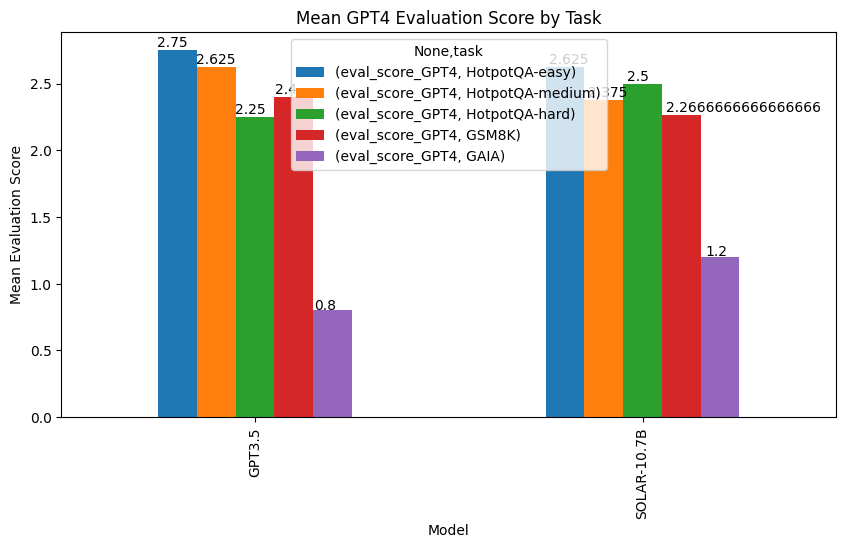

In [51]:
agg_df = (
    result_df.groupby(["agent_name", "task"])
    .agg({f"eval_score_{eval_model_name}": "mean"})
    .unstack("task")
)
display(agg_df)

ax = agg_df[
    [
        (f"eval_score_{eval_model_name}", "HotpotQA-easy"),
        (f"eval_score_{eval_model_name}", "HotpotQA-medium"),
        (f"eval_score_{eval_model_name}", "HotpotQA-hard"),
        (f"eval_score_{eval_model_name}", "GSM8K"),
        (f"eval_score_{eval_model_name}", "GAIA")
    ]
].plot.bar(
    figsize=(10, 5),
    title=f"Mean {eval_model_name} Evaluation Score by Task",
    xlabel="Model",
    ylabel="Mean Evaluation Score",
)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.01))

#### visualizations to make
- avg model score by question difficulty
- count of parsing errors and iteration limit errors

## To-do:
- Generalize evaluation code
- Make evals fully async
- Select 3-5 models to evaluate on
- Run eval
- Write blog post
- Get LangChain PR merged

## Notes

- One of the main challenges with open LLMs is ensuring they adhere to the proper markdown JSON output!
- Another is when they serve as the evaluator, they struggle to handle the default "labeled_criteria" prompt and end up hallucinating. Needs to be modified / simplified.
- I also found that GPT4 actually did pretty poor at judging correctness given the default LangChain prompt!